In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
color = sns.color_palette()

In [4]:
#%matplotlib inline

#pd.options.mode.chained_assignment = None  # default='warn'
#pd.set_option('display.max_columns', 500)

In [5]:
df_test = pd.read_csv("input/input/test.csv")
sample_submission = pd.read_csv("input/input/sample_submission.csv")
df_train = pd.read_csv("input/input/train.csv")

In [6]:
df_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [7]:
df_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [8]:
df_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


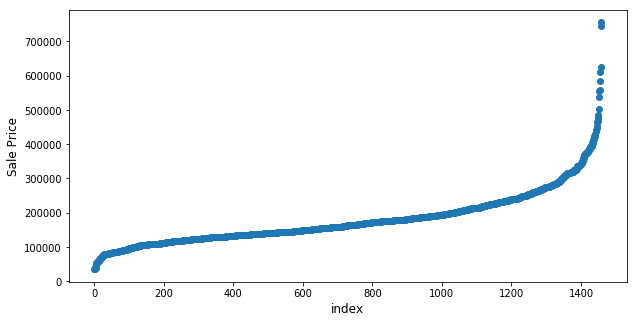

In [9]:
#график разброса цены отсортированный по возрастанию индексов
plt.figure(figsize=(10,5))
plt.scatter(range(df_train.shape[0]), np.sort(df_train.SalePrice.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.show()

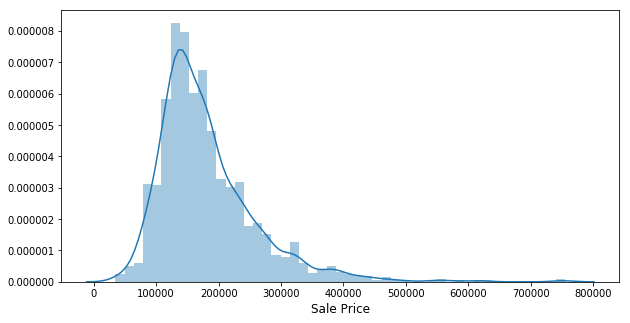

In [10]:
#гистограмма и кривая распредление цены
plt.figure(figsize=(10,5))
sns.distplot(df_train.SalePrice.values, kde=True)
plt.xlabel('Sale Price', fontsize=12)
plt.show()

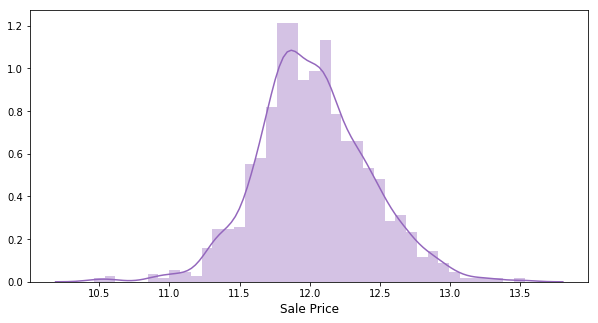

In [11]:
#берем логарифм от цены
plt.figure(figsize=(10,5))
sns.distplot(np.log(df_train.SalePrice.values), bins=40, kde=True, color=color[4])
plt.xlabel('Sale Price', fontsize=12)
plt.show()

In [12]:
df_train = pd.read_csv("input/input/train.csv", parse_dates=['YrSold', 'MoSold'])
df_test = pd.read_csv("input/input/test.csv", parse_dates=['YrSold', 'MoSold'])

#кол-во встречаемых типов данных
dtype_df = df_train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,33
1,float64,3
2,datetime64[ns],1
3,object,44


In [13]:
#кол-во пропусков по столбцам, вывод тех, у кого кол-во >1
#train.isnull().sum().sort_values(ascending=False)[:20]

missing_df = df_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'pass_count']
missing_df = missing_df.ix[missing_df['pass_count']>0]
ind = np.arange(missing_df.shape[0])

/Users/miracl6/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


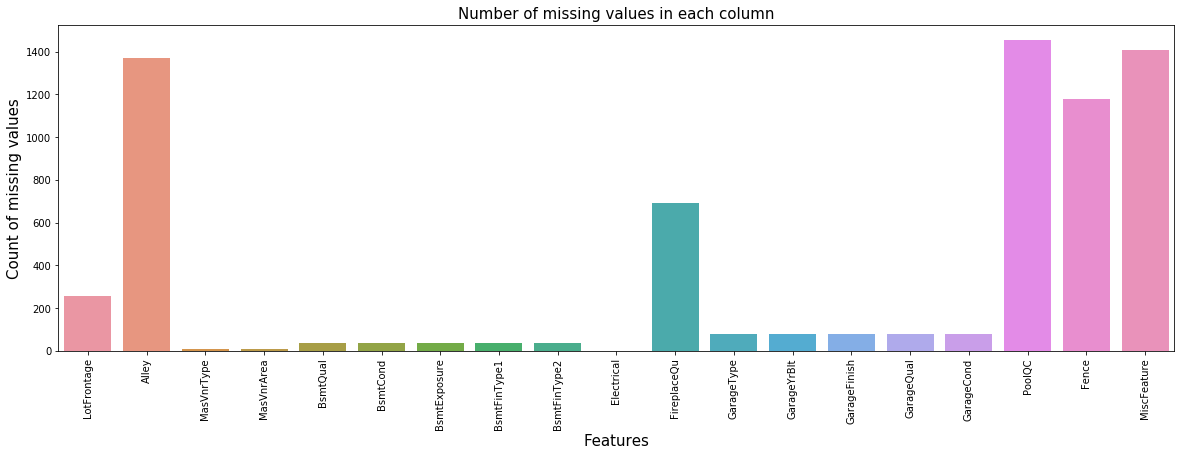

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_df.column_name.values, y=missing_df.pass_count.values)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Count of missing values', fontsize=15)
plt.title('Number of missing values in each column', fontsize=15)
plt.show()

In [15]:
#заполняем пропуски 0ми
df_train = df_train.fillna('0')

In [16]:
for i in df_train.columns:
    if(df_train[i].dtypes == object):
        print(i , df_train[i].unique())

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']
LotFrontage [65.0 80.0 68.0 60.0 84.0 85.0 75.0 '0' 51.0 50.0 70.0 91.0 72.0 66.0
 101.0 57.0 44.0 110.0 98.0 47.0 108.0 112.0 74.0 115.0 61.0 48.0 33.0
 52.0 100.0 24.0 89.0 63.0 76.0 81.0 95.0 69.0 21.0 32.0 78.0 121.0 122.0
 40.0 105.0 73.0 77.0 64.0 94.0 34.0 90.0 55.0 88.0 82.0 71.0 120.0 107.0
 92.0 134.0 62.0 86.0 141.0 97.0 54.0 41.0 79.0 174.0 99.0 67.0 83.0 43.0
 103.0 93.0 30.0 129.0 140.0 35.0 37.0 118.0 87.0 116.0 150.0 111.0 49.0
 96.0 59.0 36.0 56.0 102.0 58.0 38.0 109.0 130.0 53.0 137.0 45.0 106.0
 104.0 42.0 39.0 144.0 114.0 128.0 149.0 313.0 168.0 182.0 138.0 160.0
 152.0 124.0 153.0 46.0]
Street ['Pave' 'Grvl']
Alley ['0' 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawye

In [17]:
col_obj = []
for i in df_train.columns:
    if(df_train[i].dtypes == object):
        col_obj.append(i)

In [18]:
col_int = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'MoSold']

for i in df_train[col_int]:
    df_train[i] = df_train[i].astype('int64')

In [55]:
df_train_X = pd.get_dummies(df_train)

In [56]:
#кол-во встречаемых типов данных
dtype_df = df_train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,37
1,datetime64[ns],1
2,object,43


In [21]:
train_y

NameError: name 'train_y' is not defined

In [22]:
train_X.head()

NameError: name 'train_X' is not defined

In [23]:
train_y = np.log(df_train_X.SalePrice.values)
train_X = df_train_X.drop(["Id", "YrSold", "MoSold", "SalePrice"], axis=1)

test_X = df_test.drop(["Id", "YrSold","MoSold"], axis=1)
test_X = pd.get_dummies(test_X)

#добавляем недостающие колонки
col_diff = set(train_X.columns) - set(test_X.columns)
for i in col_diff:
    test_X[i] = 0

#xgb_model = xgb.XGBClassifier()
#xgb_reg = xgb.XGBRegressor()

housematrix=xgb.DMatrix(data=train_X, label=train_y)

'''
xgb_params = {
    'n_estimators':1000, 
    'learning_rate':0.05,
     'max_depth':4, 
    'max_features': 'sqrt',
     'min_samples_leaf':15, 
    'min_samples_split':10, 
    'loss':'huber', 
    'reg':'linear',
    'eval_metric': 'rmse',
    'random_state':5}

dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)

dtest = xgb.DMatrix(test_X, feature_names=test_X.columns.values)
dtest = xgb.DMatrix(test_X)


model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=1000)
num_boost_round = model.best_iteration'''

"\nxgb_params = {\n    'n_estimators':1000, \n    'learning_rate':0.05,\n     'max_depth':4, \n    'max_features': 'sqrt',\n     'min_samples_leaf':15, \n    'min_samples_split':10, \n    'loss':'huber', \n    'reg':'linear',\n    'eval_metric': 'rmse',\n    'random_state':5}\n\ndtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)\n\ndtest = xgb.DMatrix(test_X, feature_names=test_X.columns.values)\ndtest = xgb.DMatrix(test_X)\n\n\nmodel = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=1000)\nnum_boost_round = model.best_iteration"

In [24]:
xgb_param_grid = {'colsample_bytree':[0.3,0.5,0.7,1],'n_estimators':[50, 100, 200],
                  'max_depth':[3,5,7,10]}
xgb_inst= xgb.XGBRegressor()

xgb_grid = GridSearchCV(estimator= xgb_inst, param_grid = xgb_param_grid,
                        scoring='neg_mean_squared_error', cv=5, verbose=1)

In [25]:
scores_xgb=cross_val_score(xgb_grid,train_X,train_y,scoring='neg_mean_squared_error',cv=2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.3min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.3min finished


In [26]:
'''# plot the important features #
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()'''

'# plot the important features #\nfig, ax = plt.subplots(figsize=(15,10))\nxgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)\nplt.show()'

In [27]:
xgb_grid.fit(train_X,train_y)

'''ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred)
df_sub = pd.DataFrame({'id': df_test.Id, 'SalePrice': y_pred})

#df_sub.to_csv('input/exit_prive.csv', index=False)
df_sub.head()'''

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.6min finished


"ylog_pred = model.predict(dtest)\ny_pred = np.exp(ylog_pred)\ndf_sub = pd.DataFrame({'id': df_test.Id, 'SalePrice': y_pred})\n\n#df_sub.to_csv('input/exit_prive.csv', index=False)\ndf_sub.head()"

In [28]:
test_X = test_X[train_X.columns]

In [29]:
pred=xgb_grid.predict(test_X)

In [30]:
preds=np.exp(pred)

In [31]:
output = pd.DataFrame({'Id': df_test.Id,'SalePrice': preds}) 

In [59]:
output.head()

,Id,SalePrice
0,1461,122032.281250
1,1462,156956.968750
2,1463,189159.125000
3,1464,193489.296875
4,1465,187986.781250


In [37]:
from sklearn.metrics import mean_squared_error
import math

print(str(round(math.sqrt(mean_squared_error(sample_submission.SalePrice[:1459], output.SalePrice)))))

72622


In [57]:
sample_submission.to_csv('sample_submission_2.csv', index=False)

In [58]:
output.to_csv('sample_submission.csv', sep=',', index=False)

In [108]:
sample_submission = pd.read_csv("sample_submission_2.csv")

In [112]:
output.head()

,Id,SalePrice
0,1461,126381.914062
1,1462,162473.781250
2,1463,189643.937500
3,1464,192130.812500
4,1465,195492.656250


In [113]:
output.set_index('Id')

,SalePrice
Id,
1461,126381.914062
1462,162473.781250
1463,189643.937500
1464,192130.812500
1465,195492.656250
1466,170672.140625
1467,180999.375000
1468,162429.625000
1469,186787.656250


In [100]:
#оценка модели. среднеквадратическое отклонение
from sklearn.metrics import mean_squared_error
from math import sqrt

print("Mean Sqrt Error : " + str(round(sqrt(mean_squared_error(sample_submission.SalePrice[:1459], output.SalePrice)))))


Mean Sqrt Error : 71924
Заметим, что скор не очень высокий, так как объема данных недостаточно. 
 Можно бы было еще сделать цену категориальным признаком, немного упростив задачу (Н: от 50тыс до 100 тыс) и выбрать метрику f1, тогда могли бы получитьболее высокий скор
